In [2]:
# Copyright 2021 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""Module contains the data types used in pose estimation."""

import enum
from typing import List, NamedTuple, Tuple

import numpy as np


class BodyPart(enum.Enum):
    """Enum representing human body keypoints detected by pose estimation models."""

    NOSE = 0
    LEFT_EYE = 1
    RIGHT_EYE = 2
    LEFT_EAR = 3
    RIGHT_EAR = 4
    LEFT_SHOULDER = 5
    RIGHT_SHOULDER = 6
    LEFT_ELBOW = 7
    RIGHT_ELBOW = 8
    LEFT_WRIST = 9
    RIGHT_WRIST = 10
    LEFT_HIP = 11
    RIGHT_HIP = 12


class Point(NamedTuple):
    """A point in 2D space."""

    x: float
    y: float


class KeyPoint(NamedTuple):
    """A detected human keypoint."""

    body_part: BodyPart
    coordinate: Point
    score: float


class Person(NamedTuple):
    """A pose detected by a pose estimation model."""

    keypoints: List[KeyPoint]
    score: float
    id: int | None = None


def unnormalize_keypoints_from_padded(
    keypoints_x: np.ndarray,
    keypoints_y: np.ndarray,
    padded_height: int,
    padded_width: int,
    original_height: float,
    original_width: float,
) -> Tuple[np.ndarray, np.ndarray]:
    """Unnormalizes keypoints from a padded resized image back to the original image size.

    Args:
      keypoints_x: A numpy array with shape [17] containing normalized keypoints of x.
      keypoints_y: A numpy array with shape [17] containing normalized keypoints of y.
      padded_height: The height of the padded image.
      padded_width: The width of the padded image.
      original_height: The original height of the image.
      original_width: The original width of the image.

    Returns:
      Two numpy array with shape [17] containing keypoints in the original image size.
    """
    # Calculate the scale used for padding
    scale = min(padded_height / original_height, padded_width / original_width)

    # Calculate the dimensions of the cropped image
    crop_height = int(original_height * scale)
    crop_width = int(original_width * scale)

    # Calculate the offsets for cropping
    offset_height = (padded_height - crop_height) // 2
    offset_width = (padded_width - crop_width) // 2

    # Adjust the keypoints to remove the padding
    keypoints_x = (keypoints_x * padded_width - offset_width) / scale
    keypoints_y = (keypoints_y * padded_height - offset_height) / scale

    return keypoints_x, keypoints_y


def person_from_keypoints_with_scores(
    keypoints_with_scores: np.ndarray,
    image_height: float,
    image_width: float,
    keypoint_score_threshold: float = 0.1,
) -> Person:
    """Creates a Person instance from single pose estimation model output.

    Args:
      keypoints_with_scores: Output of the TFLite pose estimation model. A numpy
        array with shape [17, 3]. Each row represents a keypoint: [y, x, score].
      image_height: height of the image in pixels.
      image_width: width of the image in pixels.
      keypoint_score_threshold: Only use keypoints with above this threshold to
        calculate the person average score.

    Returns:
      A Person instance.
    """

    # only take the first 13 keypoints (legs not included)
    kpts_x = keypoints_with_scores[:13, 1]
    kpts_y = keypoints_with_scores[:13, 0]
    scores = keypoints_with_scores[:13, 2]

    # Convert keypoints to the input image coordinate system.
    keypoints = []
    ori_kpts_x, ori_kpts_y = unnormalize_keypoints_from_padded(
        kpts_x, kpts_y, 256, 256, image_height, image_width
    )
    for i in range(scores.shape[0]):
        keypoints.append(
            KeyPoint(
                BodyPart(i), Point(int(ori_kpts_x[i]), int(ori_kpts_y[i])), scores[i]
            )
        )

    # Calculate person score by averaging keypoint scores.
    scores_above_threshold = list(
        filter(lambda x: x > keypoint_score_threshold, scores)
    )
    person_score = np.average(scores_above_threshold)

    return Person(keypoints, person_score)


class Category(NamedTuple):
    """A classification category."""

    label: str
    score: float

In [3]:
import csv
import os
import sys
import tempfile
from typing import List, Tuple
import tqdm

import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
import matplotlib.pyplot as plt
import polars as pl

In [4]:
DATA_DIR = 'data'
IMAGES_OUT_DIR = os.path.join(DATA_DIR, 'poses_images_out')
CSVS_OUT = os.path.join(DATA_DIR, 'data.csv')
image_path = '/content/ComfyUI_00016_.png'

# map edges to a RGB color
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): (147, 20, 255),
    (0, 2): (255, 255, 0),
    (1, 3): (147, 20, 255),
    (2, 4): (255, 255, 0),
    (0, 5): (147, 20, 255),
    (0, 6): (255, 255, 0),
    (5, 7): (147, 20, 255),
    (7, 9): (147, 20, 255),
    (6, 8): (255, 255, 0),
    (8, 10): (255, 255, 0),
    (5, 6): (0, 255, 255),
    (5, 11): (147, 20, 255),
    (6, 12): (255, 255, 0),
    (11, 12): (0, 255, 255),
}

# A list of distictive colors
COLOR_LIST = [
    (47, 79, 79),
    (139, 69, 19),
    (0, 128, 0),
    (0, 0, 139),
    (255, 0, 0),
    (255, 215, 0),
    (0, 255, 0),
    (0, 255, 255),
    (255, 0, 255),
    (30, 144, 255),
    (255, 228, 181),
    (255, 105, 180),
]

In [5]:
model = hub.load("https://www.kaggle.com/models/google/movenet/TensorFlow2/singlepose-thunder/4")
movenet = model.signatures['serving_default']

In [6]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    return img

In [7]:
def detect(input_tensor: tf.Tensor) -> Person:
    """Runs detection on an input image.

    Args:
      input_tensor: A [height, width, 3] Tensor of type tf.float32.
        Note that height and width can be anything since the image will be
        immediately resized according to the needs of the model within this
        function.

    Returns:
      A Person entity detected by the MoveNet.SinglePose.
    """
    image_height, image_width, channel = input_tensor.shape
    # Resize with pad to keep the aspect ratio and fit the expected size.
    input_tensor = tf.cast(tf.image.resize_with_pad(input_tensor, 256, 256), dtype=tf.int32)
    # Add a batch dimension.
    input_tensor = tf.expand_dims(input_tensor, axis=0)
    keypoints_with_scores = movenet(input_tensor)['output_0']
    # Reshape the keypoints_with_scores to be a [17, 3] tensor.
    keypoints_with_scores = tf.squeeze(keypoints_with_scores)
    return person_from_keypoints_with_scores(keypoints_with_scores.numpy(), image_height, image_width,)

In [8]:
def visualize(
        image: np.ndarray,
        list_persons: List[Person],
        keypoint_color: Tuple[int, ...] = None,
        keypoint_threshold: float = 0.05,
        instance_threshold: float = 0.1,
) -> np.ndarray:
    """Draws landmarks and edges on the input image and return it.

    Args:
      image: The input RGB image.
      list_persons: The list of all "Person" entities to be visualize.
      keypoint_color: the colors in which the landmarks should be plotted.
      keypoint_threshold: minimum confidence score for a keypoint to be drawn.
      instance_threshold: minimum confidence score for a person to be drawn.

    Returns:
      Image with keypoints and edges.
    """
    for person in list_persons:
        if person.score < instance_threshold:
            continue

        keypoints = person.keypoints

        # Assign a color to visualize keypoints.
        if keypoint_color is None:
            if person.id is None:
                # If there's no person id, which means no tracker is enabled, use
                # a default color.
                person_color = (0, 255, 0)
            else:
                # If there's a person id, use different color for each person.
                person_color = COLOR_LIST[person.id % len(COLOR_LIST)]
        else:
            person_color = keypoint_color

        # Draw all the landmarks
        for i in range(len(keypoints)):
            if keypoints[i].score >= keypoint_threshold:
                cv2.circle(image, keypoints[i].coordinate, 17, person_color, 4)

        # Draw all the edges
        for edge_pair, edge_color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
            if (keypoints[edge_pair[0]].score > keypoint_threshold and
                    keypoints[edge_pair[1]].score > keypoint_threshold):
                cv2.line(image, keypoints[edge_pair[0]].coordinate,
                         keypoints[edge_pair[1]].coordinate, edge_color, 15)

    return image

In [9]:
def draw_prediction_on_image(image, person, close_figure=True, keep_input_size=False):
    """Draws the keypoint predictions on image.

    Args:
      image: An numpy array with shape [height, width, channel] representing the
        pixel values of the input image.
      person: A person entity returned from the MoveNet.SinglePose model.
      close_figure: Whether to close the plt figure after the function returns.
      keep_input_size: Whether to keep the size of the input image.

    Returns:
      An numpy array with shape [out_height, out_width, channel] representing the
      image overlaid with keypoint predictions.
    """
    # Draw the detection result on top of the image.
    image_np = visualize(image, [person])

    # Plot the image with detection results.
    height, width, channel = image.shape
    aspect_ratio = float(width) / height
    display_height = 512
    display_width = int(display_height * aspect_ratio)
    resized_image = cv2.resize(image_np, (display_width, display_height))
    fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
    im = ax.imshow(resized_image)

    if close_figure:
        plt.close(fig)

    if not keep_input_size:
        image_np = tf.image.resize_with_pad(image_np, 256, 256).numpy()

    return image_np

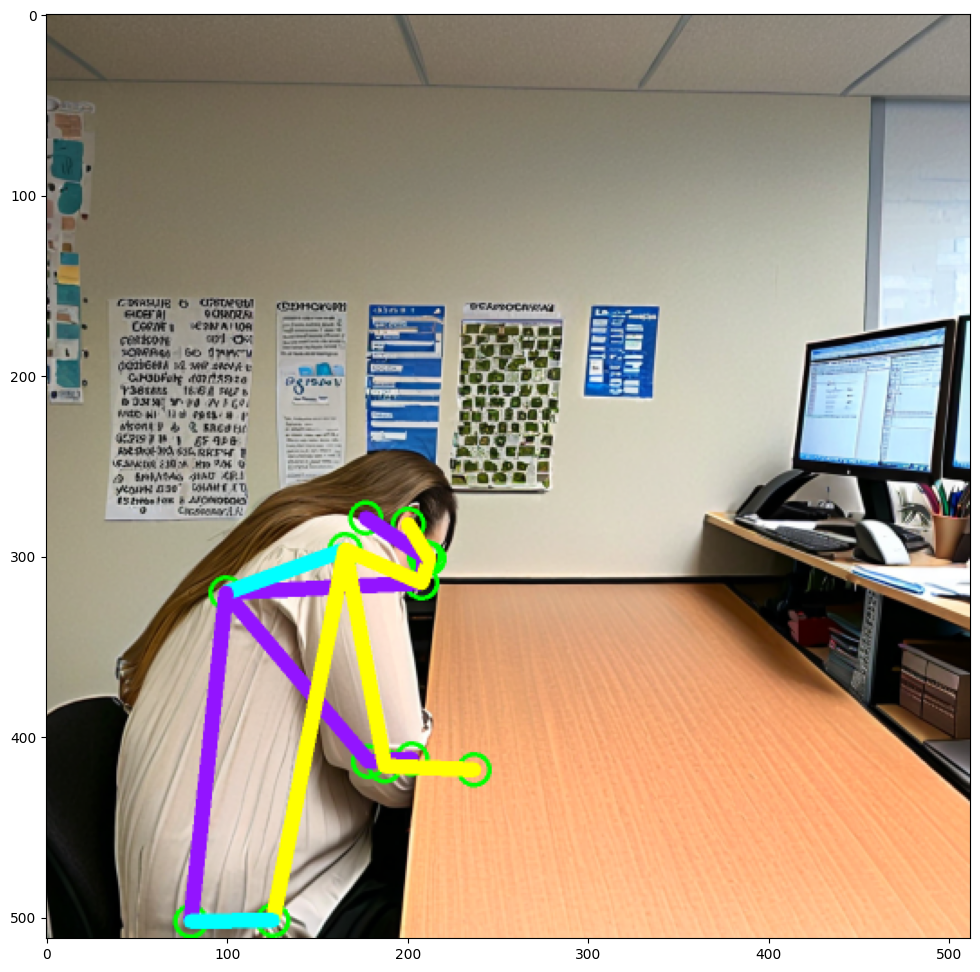

In [10]:
# Load the image
# image = load_image(os.path.join(DATA_DIR, 'original', image_path))
# load generated image
image = load_image(image_path)

# Detect keypoints
person = detect(image)

# Draw keypoints on the image
image_with_keypoints = draw_prediction_on_image(image.numpy(), person, close_figure=False, keep_input_size=True)

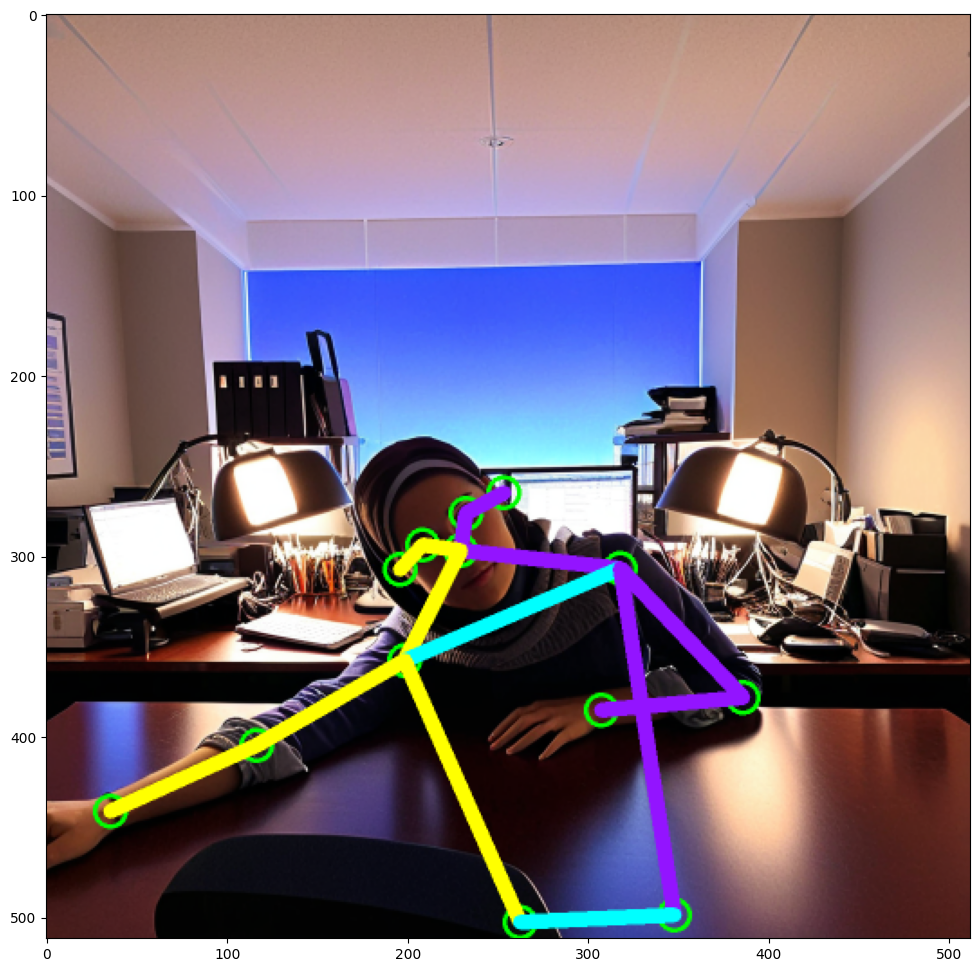

In [11]:
# Load the image
# image = load_image(os.path.join(DATA_DIR, 'original', image_path))
# load generated image
image = load_image('/content/ComfyUI_00013_.png')

# Detect keypoints
person = detect(image)

# Draw keypoints on the image
image_with_keypoints = draw_prediction_on_image(image.numpy(), person, close_figure=False, keep_input_size=True)

https://www.tensorflow.org/lite/tutorials/pose_classification#define_a_keras_model_for_pose_classification

In [ ]:
class MoveNetPreprocessor(object):
    """Helper class to preprocess pose sample images for classification."""

    def __init__(self,
                 images_in_folder,
                 images_out_folder,
                 csvs_out_path,
                 batch_size=32):
        """Creates a preprocessor to detection pose from images and save as CSV.

        Args:
          images_in_folder: Path to the folder with the input images.
          images_out_folder: Path to write the images overlay with detected landmarks.
          csvs_out_path: Path to write the CSV containing the detected landmark coordinates.
          batch_size: Number of images to process in a batch.
        """
        self._images_in_folder = images_in_folder
        self._images_out_folder = images_out_folder
        self._csvs_out_path = csvs_out_path
        self._batch_size = batch_size
        self._messages = []

        # Create a temp dir to store the pose CSVs per class
        self._csvs_out_folder_per_class = tempfile.mkdtemp()

        # Get list of pose classes and print image statistics
        self._pose_class_names = sorted(
            [n for n in os.listdir(self._images_in_folder) if not n.startswith('.') and os.path.isdir(os.path.join(self._images_in_folder, n))]
        )

    def process(self, per_pose_class_limit=None, detection_threshold=0.1):
        """Preprocesses images in the given folder.
        Args:
          per_pose_class_limit: Number of images to load.
          detection_threshold: Only keep images with all landmark confidence score above this threshold.
        """
        for pose_class_name in self._pose_class_names:
            print('Preprocessing', pose_class_name, file=sys.stderr)

            images_in_folder = os.path.join(self._images_in_folder, pose_class_name)
            images_out_folder = os.path.join(self._images_out_folder, pose_class_name)
            csv_out_path = os.path.join(self._csvs_out_folder_per_class, pose_class_name + '.csv')
            if not os.path.exists(images_out_folder):
                os.makedirs(images_out_folder)

            with open(csv_out_path, 'w') as csv_out_file:
                csv_out_writer = csv.writer(csv_out_file, delimiter=',', quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
                image_paths = sorted([os.path.join(images_in_folder, n) for n in os.listdir(images_in_folder) if not n.startswith('.') and n.endswith('JPG')])
                if per_pose_class_limit is not None:
                    image_paths = image_paths[:per_pose_class_limit]

                dataset = tf.data.Dataset.from_tensor_slices(image_paths)
                dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
                dataset = dataset.batch(self._batch_size)
                dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

                valid_image_count = 0

                for batch in tqdm.tqdm(dataset):
                    persons = self._detect_batch(batch, detection_threshold)
                    for i, person in enumerate(persons):
                        image_path = image_paths[valid_image_count + i]
                        image_name = os.path.basename(image_path)

                        if person is None:
                            self._messages.append('Skipped ' + image_path + '. No pose was confidently detected.')
                            continue

                        valid_image_count += 1
                        output_overlay = draw_prediction_on_image(batch[i].numpy().astype(np.uint8), person, close_figure=True, keep_input_size=True)
                        output_frame = cv2.cvtColor(output_overlay, cv2.COLOR_RGB2BGR)
                        cv2.imwrite(os.path.join(images_out_folder, image_name), output_frame)

                        pose_landmarks = np.array([[keypoint.coordinate.x, keypoint.coordinate.y, keypoint.score] for keypoint in person.keypoints], dtype=np.float32)
                        coordinates = pose_landmarks.flatten().astype(str).tolist()
                        csv_out_writer.writerow([image_name] + coordinates)

                if not valid_image_count:
                    raise RuntimeError('No valid images found for the "{}" class.'.format(pose_class_name))

        # Print the error message collected during preprocessing.
        print('\n'.join(self._messages))

        # combine all per-class CSVs into a single output
        all_landmarks_df = self._all_landmarks_as_dataframe()
        all_landmarks_df.write_csv(self._csvs_out_path)

    def _detect_batch(self, batch, detection_threshold):
        persons = []
        for image in batch:
            person = detect(image)
            if min([keypoint.score for keypoint in person.keypoints]) < detection_threshold:
                persons.append(None)
            else:
                persons.append(person)
        return persons

    def _all_landmarks_as_dataframe(self):
        total_df = None
        for class_index, class_name in enumerate(self._pose_class_names):
            csv_out_path = os.path.join(self._csvs_out_folder_per_class, class_name + '.csv')
            per_class_df = pl.read_csv(csv_out_path, has_header=False)

            # add the labels
            per_class_df = per_class_df.with_columns([
                pl.lit(class_index).alias('class_no'),
                pl.lit(class_name).alias('class_name')
            ])

            # add the folder name to the filename
            folder_name = pl.lit(os.path.join(class_name, ''))
            original_filename = pl.col(per_class_df.columns[0]).cast(pl.Utf8)
            new_filename = folder_name + original_filename
            per_class_df = per_class_df.with_columns([new_filename.alias(per_class_df.columns[0])])

            if total_df is None:
                total_df = per_class_df
            else:
                total_df = pl.concat([total_df, per_class_df])

        list_name = [[bodypart.name + '_x', bodypart.name + '_y', bodypart.name + '_score'] for bodypart in BodyPart]
        header_name = []
        for columns_name in list_name:
            header_name += columns_name
        header_name = ['file_name'] + header_name
        header_map = {total_df.columns[i]: header_name[i] for i in range(len(header_name))}

        total_df = total_df.rename(header_map)
        return total_df

In [ ]:
preprocessor = MoveNetPreprocessor(
    images_in_folder=os.path.join(DATA_DIR, 'original'),
    images_out_folder=IMAGES_OUT_DIR,
    csvs_out_path=CSVS_OUT,
    batch_size=4,
)

preprocessor.process()

Preprocessing ergonomis
100%|██████████| 225/225 [12:30<00:00,  3.34s/it]
Preprocessing non-ergonomis
100%|██████████| 206/206 [09:53<00:00,  2.88s/it]

Skipped data\original\ergonomis\DSC02446.JPG. No pose was confidently detected.
Skipped data\original\ergonomis\DSC02453.JPG. No pose was confidently detected.
Skipped data\original\ergonomis\DSC02541 - Copy.JPG. No pose was confidently detected.
Skipped data\original\ergonomis\DSC02545.JPG. No pose was confidently detected.
Skipped data\original\ergonomis\DSC02560 - Copy.JPG. No pose was confidently detected.
Skipped data\original\ergonomis\DSC02559.JPG. No pose was confidently detected.
Skipped data\original\ergonomis\DSC02628 - Copy.JPG. No pose was confidently detected.
Skipped data\original\ergonomis\DSC02626.JPG. No pose was confidently detected.
Skipped data\original\ergonomis\DSC02795.JPG. No pose was confidently detected.
Skipped data\original\ergonomis\DSC02825.JPG. No pose was confidently detected.
Skipped data\original\ergonomis\DSC02854.JPG. No pose was confidently detected.
Skipped data\original\ergonomis\DSC02951 - Copy.JPG. No pose was confidently detected.
Skipped data